<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2C_mdl1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Neurogym

In [ ]:
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 11100, done.
remote: Counting objects: 100% (1002/1002), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 11100 (delta 928), reused 896 (delta 896), pack-reused 10098 (from 1)
Receiving objects: 100% (11100/11100), 8.17 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (8333/8333), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793126 sha256=d035ee1849069de28e9c913dac8ee69a073729d8c6e9e93f886ba044d5051d25
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existing i

### Imports

In [ ]:
import neurogym as ngym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Define a simple LSTM model

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_lstm_layers = 2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_lstm_layers) # n LSTM layers
        self.fc = nn.Linear(hidden_size, output_size) # Fully connected layer

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        out = self.fc(lstm_output)
        return out, lstm_output

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creating dataset and adjusting parameters

In [ ]:
config = {
    'dt': 200, # Timestep parameter
    'hidden_size': 32, # Hidden size for your LSTM
    'batch_size': 32, # Batch size for training
    'seq_len': 50, # Sequence length for input data
    'envid': 'ReadySetGo-v0', # Task name
    'gain': 2, # Custom gain
    'prod_margin': 10, # Custom production margin
}

env_kwargs = {
    'dt': config['dt'], # Assing timestep parameter
    'gain': config['gain'],  # Controls the measure that the agent has to produce
    'prod_margin': config['prod_margin'], # Controls the interval around the ground truth production time within which the agent receives proportional reward
}
config['env_kwargs'] = env_kwargs

dataset = ngym.Dataset(config['envid'], env_kwargs=config['env_kwargs'], batch_size=config['batch_size'], seq_len=config['seq_len']) # Generate dataset
env = dataset.env

inputs, target = dataset() # Assing inputs and targets
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0] # Find dimensions for data
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Input has shape (SeqLen, Batch, Dim) = torch.Size([50, 32, 3])
Target has shape (SeqLen, Batch) = (50, 32)


### Training the model

In [ ]:
iter_steps = 3000 # Training loops
report_freq = 100 # How often a report on is returned

net = LSTMNet(input_size, config['hidden_size'], output_size, num_lstm_layers = 2) # Create an instance of the LSTM

def train_model(net, dataset, iter_steps, report_freq):

    optimizer = optim.Adam(net.parameters(), lr=0.0003) # Adam optimiser
    criterion = nn.CrossEntropyLoss() # Loss funciton

    running_loss = 0
    running_acc = 0
    losses = []
    accuracies = []
    start_time = time.time() # Start training timer

    for i in range(iter_steps):  # Loop over training batches
        inputs, labels = dataset()  # Generate a set of data
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        optimizer.zero_grad()  # Reset gradients
        output, _ = net(inputs)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)  # Calculate loss
        loss.backward()
        optimizer.step()  # Update weights

        batch_acc = (torch.argmax(output, dim=1) == labels).sum().item() / labels.shape[0]  # Current batch accuracy
        losses.append(loss.item())
        accuracies.append(batch_acc)

        if i % report_freq == report_freq - 1:
            running_loss = sum(losses[-report_freq:]) / report_freq
            running_acc = sum(accuracies[-report_freq:]) / report_freq
            print('Step {}, Loss {:0.4f}, Accuracy {:0.4f}, Time {:0.1f}s'.format(
                i + 1, running_loss, running_acc, time.time() - start_time))
            running_loss = 0 # Reset metrics for next report
            running_acc = 0
    return net, losses, accuracies

net, losses, accuracies = train_model(net, dataset, iter_steps, report_freq) # Call the training function

### Sparsity

In [ ]:
sparsity = 0
total_params = 0
for param in net.parameters():
    if param.requires_grad: # Only check sparsity on weight parameters
        total_params += param.numel() # Number of weights
        sparsity += torch.sum(param <= 0.00001).item() # Number of weights very close to 0

sparsity_ratio = sparsity / total_params # Ratio of weights close to 0 to total weights
print('Model Sparsity Ratio:', sparsity_ratio)

Sparsity ratio: 0.508


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot loss and accuracy over iterations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


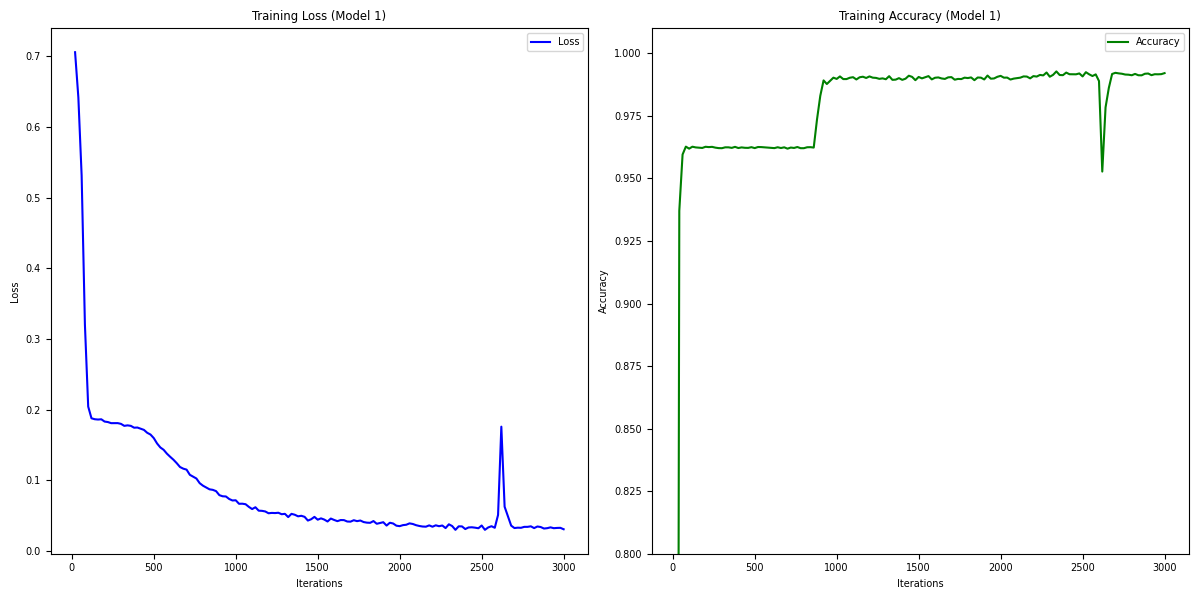

In [ ]:
avg_losses = []
avg_accuracies = []
report_freq = 20
for i in range(report_freq - 1, len(losses), report_freq):
    avg_losses.append(sum(losses[i-report_freq+1:i+1]) / report_freq)
    avg_accuracies.append(sum(accuracies[i-report_freq+1:i+1]) / report_freq)

iterations = range(report_freq, len(losses) + 1, report_freq)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(iterations, avg_losses, label='Loss', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss (Model 1)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(iterations, avg_accuracies, label='Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.01)
plt.title('Training Accuracy (Model 1)')
plt.legend()

plt.tight_layout()
plt.show()

### Plot weight matrix

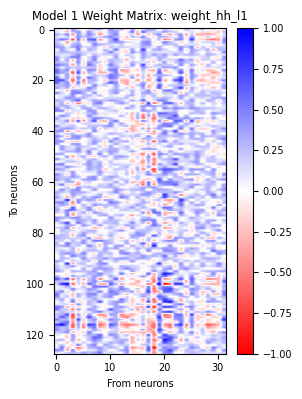

In [ ]:
weight_name = 'weight_hh_l1'  # Replace with the desired weight matrix name

W = getattr(net.lstm, weight_name).detach().numpy()
wlim = np.max(np.abs(W))

W_min = np.min(W)
W_max = np.max(W)
W = 2 * (W - W_min) / (W_max - W_min) - 1
wlim = np.max(np.abs(W))

plt.figure(figsize=(3, 4))
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim, aspect='auto')  # 'aspect=auto' ensures good scaling
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title(f'Model 1 Weight Matrix: {weight_name}')

plt.tight_layout()
plt.show()

### Testing

In [ ]:
dataset = ngym.Dataset(config['envid'], env_kwargs=config['env_kwargs'], batch_size=1, seq_len=config['seq_len']) # Generate dataset
env = dataset.env # Reset environment

env.reset(no_step=True)
all_activity = []
all_labels = []

for i in range(1000):
    env.new_trial()
    test_inputs, test_labels = dataset()
    test_inputs = torch.from_numpy(test_inputs).type(torch.float)
    test_labels = torch.from_numpy(test_labels.flatten()).type(torch.long)
    test_accs = []
    with torch.no_grad():
        test_output, act = net(test_inputs)
        test_output = test_output.view(-1, output_size)
        criterion = nn.CrossEntropyLoss()
        test_loss = criterion(test_output, test_labels)
        all_activity.append(act.numpy())
        all_labels.append(test_labels.numpy())
        test_acc = (torch.argmax(test_output, dim=1) == test_labels).sum().item() / test_labels.shape[0]
        test_accs.append(test_acc)

print('Test Accuracy:', np.mean(test_accs))

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Test Accuracy: 0.98


### PCA

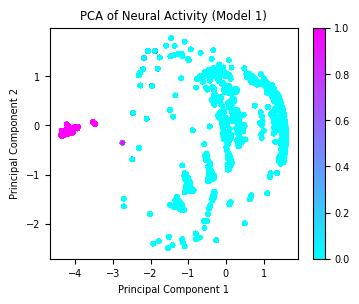

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

activity = np.vstack(all_activity)
labels = np.concatenate(all_labels)

num_trials, seq_len, num_features = activity.shape
activity = activity.reshape(num_trials, seq_len * num_features)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(activity)

plt.figure(figsize=(4, 3))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='cool' ,s=7)
plt.colorbar()  # Color by test labels
plt.title('PCA of Neural Activity (Model 1)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
ones = labels == 1
pc1_ones = pca_result[ones, 0]
print(np.where(pca_result[:,0] == max(pc1_ones)))

all_labels[5]



(array([  203,   253,   303,   453,   503,   553,   653,   703,   753,
         803,   953,  1153,  1203,  1253,  1403,  1503,  1553,  1603,
        1653,  1703,  1753,  1803,  1903,  1953,  2153,  2353,  2403,
        2453,  2503,  2553,  2703,  2753,  2803,  2853,  2903,  2953,
        3003,  3053,  3153,  3203,  3303,  3353,  3403,  3553,  3653,
        3703,  3753,  3803,  3953,  4003,  4053,  4103,  4153,  4303,
        4353,  4403,  4453,  4503,  4603,  4653,  4703,  4753,  4803,
        4853,  4903,  5103,  5153,  5353,  5403,  5453,  5503,  5553,
        5703,  5753,  5803,  5903,  5953,  6003,  6053,  6103,  6153,
        6203,  6253,  6303,  6453,  6553,  6603,  6653,  6703,  6753,
        6803,  6853,  6903,  7103,  7153,  7303,  7353,  7403,  7453,
        7503,  7553,  7603,  7653,  7753,  7803,  7953,  8003,  8053,
        8103,  8153,  8253,  8303,  8353,  8403,  8453,  8553,  8603,
        8653,  8753,  8803,  8853,  8903,  8953,  9053,  9103,  9153,
        9203,  9253

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])